Data Mining for Coronavirus (Covid-19) Patient's Recovery

Authors: Alexander Berg, Josefin Paananen

Date: 2020-10-27

In [3]:
import pydotplus
import pandas as pd 
import seaborn as sns 
import numpy as np 
import datetime as dt 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.tree import tree
from IPython.display import Image
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score,classification_report,precision_recall_curve,roc_curve




%matplotlib inline 

#Set a standard figure sized for all graphs
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Exploratory Data Analysis

In [5]:
# Load the data set
patient = pd.read_csv('PatientInfo.csv')

In [6]:
#Explore the first 5 rows
patient.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [7]:
#Return information about the raw data
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          5165 non-null   int64 
 1   sex                 4043 non-null   object
 2   age                 3785 non-null   object
 3   country             5165 non-null   object
 4   province            5165 non-null   object
 5   city                5071 non-null   object
 6   infection_case      4246 non-null   object
 7   infected_by         1346 non-null   object
 8   contact_number      791 non-null    object
 9   symptom_onset_date  690 non-null    object
 10  confirmed_date      5162 non-null   object
 11  released_date       1587 non-null   object
 12  deceased_date       66 non-null     object
 13  state               5165 non-null   object
dtypes: int64(1), object(13)
memory usage: 565.0+ KB


In [8]:
patient.shape

(5165, 14)

In [9]:
# Check how many unique values are in the state column
patient.state.unique()

array(['released', 'deceased', 'isolated'], dtype=object)

In [10]:
# Remove isolated state and its rows from the data set
patient = patient[patient.state != 'isolated']

In [11]:
# Drop duplicate rows from the data set
patient.drop_duplicates(inplace = True)

In [12]:
# Reset index of the data set
patient.reset_index(inplace = True, drop = True)

In [13]:
#We will forward fill the missing rows meaning those rows will be filled with the previous rows value respectively
patient.fillna(method='ffill', inplace=True)

In [14]:
#Since 'deceased_date' first rows are missing the forward fill won't affect this column because it has no previous values to fill the missing rows with
#so we will drop the missing values in this column manually
patient.dropna(axis=0,subset=['deceased_date'], inplace=True)

In [15]:
#Reset index
patient.reset_index(inplace = True, drop = True)


In [16]:
#Remove tailing s from the age column by using lambda function 
patient['age'] = patient.age.apply(lambda x: x[:-1]).astype(int)

In [17]:
#Convert all date columns into date time columns

patient['confirmed_date'] = pd.to_datetime(patient['confirmed_date'])
patient['released_date'] = pd.to_datetime(patient['released_date'])
patient['deceased_date'] = pd.to_datetime(patient['deceased_date'])

In [18]:
# Duration of infection from confirmed to release and death
patient['time_to_release'] = patient['released_date'] - patient['confirmed_date']
patient['time_to_death'] = patient['deceased_date'] - patient['confirmed_date']

In [19]:
# Extract days from the time delta value
patient['time_to_release'] = patient.time_to_release.apply(lambda x: x.days).astype(int)
patient['time_to_death'] = patient.time_to_death.apply(lambda x: x.days).astype(int)


In [20]:
#Convert contact number to integer
patient['contact_number'] = patient['contact_number'].replace('-', 0) 
patient['contact_number'] = patient['contact_number'].astype(float) 
patient['contact_number'] = patient['contact_number'].astype(int)

#Convert time to release to integer
patient['time_to_release'] = patient['time_to_release'].astype(float) 
patient['time_to_release'] = patient['time_to_release'].astype(int)

#Convert time to death to integer
patient['time_to_death'] = patient['time_to_death'].astype(float) 
patient['time_to_death'] = patient['time_to_death'].astype(int)

In [21]:
#This function is used to group patients by age in steps of 10 years. It returns the age range of the patient as a string

def group_age(age):
        if age % 10 != 0:
            lower = int(math.floor(age / 10.0)) * 10
            upper = int(math.ceil(age / 10.0)) * 10 - 1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age + 9) 
            return f"{lower}-{upper}"



patient["age_group"] = patient["age"].apply(group_age)

In [22]:
#Dropping useless columns
patient.drop(columns=['patient_id','confirmed_date','released_date','deceased_date','province','city','country','infected_by','symptom_onset_date'], axis = 1, inplace = True)

In [23]:
#Reset index
patient.reset_index(inplace = True, drop = True)

In [24]:
#Show first rows
patient.head()

,sex,age,infection_case,contact_number,state,time_to_release,time_to_death,age_group
0,female,50,overseas inflow,3,deceased,31,5,50-59
1,male,70,Shincheonji Church,3,released,12,4,70-79
2,female,60,Shincheonji Church,3,released,7,4,60-69
3,female,50,Shincheonji Church,3,released,9,4,50-59
4,female,50,Shincheonji Church,3,released,8,4,50-59


In [25]:
#Get the data types
patient.dtypes

sex                object
age                 int64
infection_case     object
contact_number      int64
state              object
time_to_release     int64
time_to_death       int64
age_group          object
dtype: object

In [26]:
#Drop negative values
patient.time_to_death.unique()

array([   5,    4,    7,    8,    0,    6,    1,    2,   35,   33,   18,
         17,   16,   15,   -5,   -8,  -17,  -22,  -24,  -81,   49,   13,
         10,   -1,   -3,   -2,   -4,   -7,  -10,  -11,  -14,  -16,  -18,
        -19,  -20,  -21,  -23,  -25,  -26,  -27,  -29,  -31,  -32,  -35,
        -38,  -39,  -40,  -41,  -49,  -54,  -55,  -61,  -65,  -66,   12,
        -30,   11,   52,   51,   42,   39,   38,   37,   27,   -9,  -28,
         70,   68,   67,   66,   65,   36,   64,   32,   30,   28,   24,
         21,   19,   14,  -42,  -13,  -33,  -48,  -51,  -59,   23,   22,
         20,    9,    3,   59,   58,   55,   50,   34,   -6,  -12,  -15,
        -76,  -44,   48,   41,   95,   93,   90,   89,   88,   86,   82,
         81,   80,   79,   78,   77,   76,   73,   72,   69,   61,   60,
         57,   53,   94,   40,   87,   85,   84,   83,   75,   62,   56,
         54,   44,   29,  116,  109,   96,   92,   91,   46,   45,   25,
        -62,   31,  -50,  -52,  -63,   26,   43,   

In [27]:
#Drop negative values
patient.time_to_release.unique()

array([ 31,  12,   7,   9,   8,   6,   3,   2,   1,   0,  -1,  -2,  -3,
        -7, -10,  17,  15,  28,  26,  24,  13,  25,  44,  16,  11,  27,
        72,  41,  23,  36,  49,  69,  22,  19,  35,  34,  21,  10,  46,
        20,  39,  50,  37,  38,  18,  29,  63,  14,   4,  33,  53,  52,
        40,   5,  30,  32,  54,  48,  47,  45,  42,  64,  51, -25,  43,
        67,  71, 108,  70,  87,  77, 114,  65,  74,  62,  61,  66,  59,
        57,  93,  94,  95, 118, 116, 115, 113, 112, 110, 109, 106, 105,
        96,  92,  90,  89,  86,  82,  76,  75,  60,  -6,  -8,  -9, -11,
       -22, -17,  68,  56, -21,  55,  58, 127, 126, -12, -15])

In [28]:
#Dropping negative values for time to death and time to release
patient.drop(patient[(patient.time_to_release < 0) | (patient.time_to_death < 0 )].index, inplace=True)

In [29]:
#Get the final shape of data set
patient.shape

(1427, 8)

In [30]:
#Verify that no values are missing
patient.isna().sum()

sex                0
age                0
infection_case     0
contact_number     0
state              0
time_to_release    0
time_to_death      0
age_group          0
dtype: int64

Preprocessing/data cleaning is now complete and we'll move on to visualization

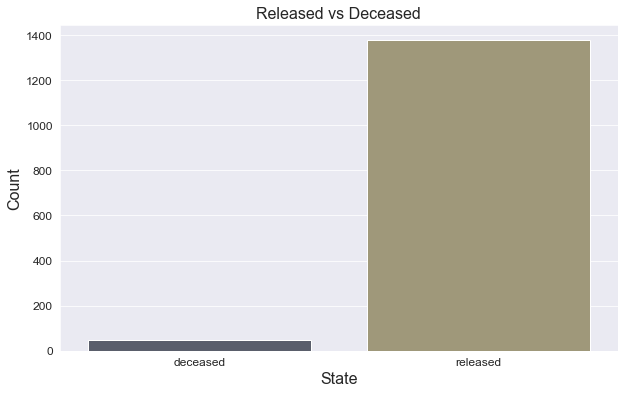

Total number of released:  1377
Total number of deceased:  50


In [31]:
#Barplot showing released vs deceased

#The data-set is slightly biased towards more number of released So, later on when the data-set will be split into train and test set, we will use stratify??.
#Check distribution?
sns.set_style("darkgrid")

ax = sns.countplot(x='state', data=patient, palette='cividis')

plt.title('Released vs Deceased', fontsize=16)
plt.xlabel('State', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print('Total number of released: ', len(patient[patient['state'] == 'released']))
print('Total number of deceased: ', len(patient[patient['state'] == 'deceased']))

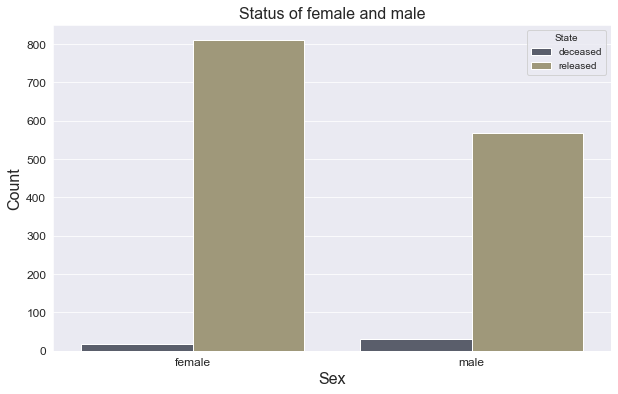

In [32]:
#Barplot showing the state of female vs male 
sns.set_style("darkgrid")
ax = sns.countplot(x='sex', data=patient, hue='state', palette='cividis')

plt.title('Status of female and male', fontsize=16)
plt.xlabel('Sex', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='State', loc='upper right')
plt.show()

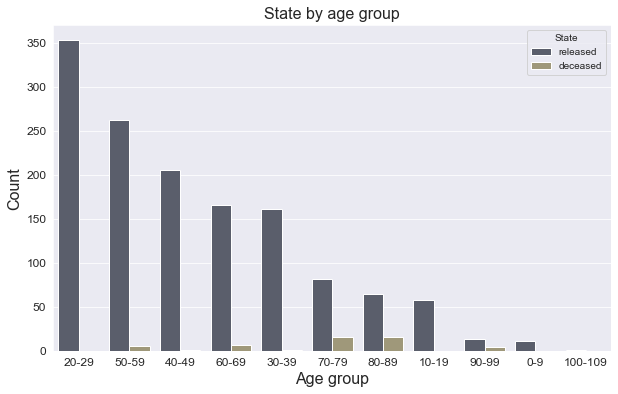

In [33]:
#Status of each age group
sns.set_style("darkgrid")
age_groups = list(patient['age_group'].value_counts().index)


ax = sns.countplot(x = 'age_group',
            hue='state',
            order=age_groups,
            hue_order=['released', 'deceased'],
            palette='cividis',
            data=patient)
plt.title('State by age group', fontsize=16)
plt.xlabel('Age group', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='State', loc='upper right')
plt.show()

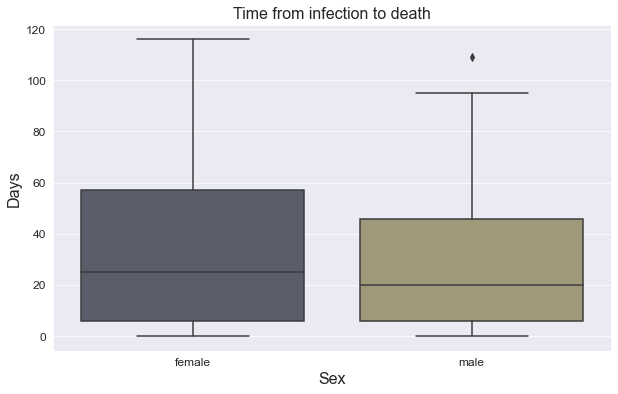

In [34]:
# Time to death from infection to death among the sexes
sns.boxplot(x='sex',
            y='time_to_death',           
            data=patient,
            palette='cividis')
plt.title('Time from infection to death',fontsize=16)
plt.xlabel('Sex', fontsize=16)
plt.ylabel('Days', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

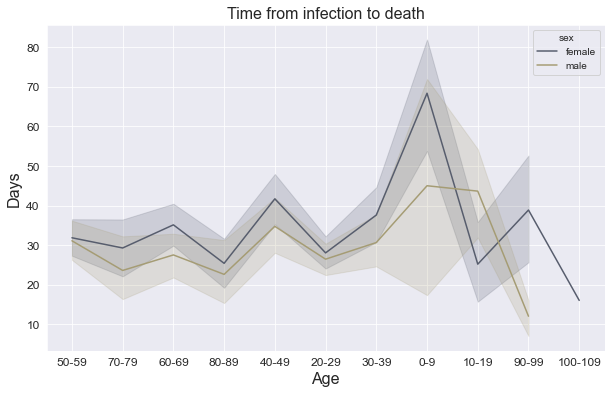

In [35]:
#Lineplot showing time from infection to death among the age groups
sns.lineplot(x='age_group',
            y='time_to_death',           
            data=patient,
            hue='sex',
            palette='cividis')
plt.title('Time from infection to death',fontsize=16)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Days', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

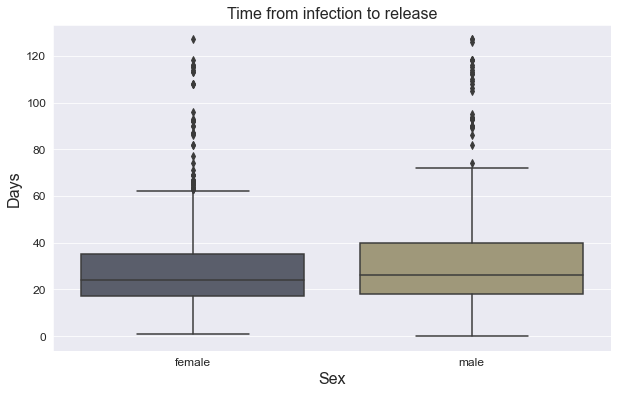

In [36]:
# Time to release among the sexes
sns.boxplot(x='sex',
            y='time_to_release',           
            data=patient,
            palette='cividis')
plt.title('Time from infection to release',fontsize=16)
plt.xlabel('Sex', fontsize=16)
plt.ylabel('Days', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

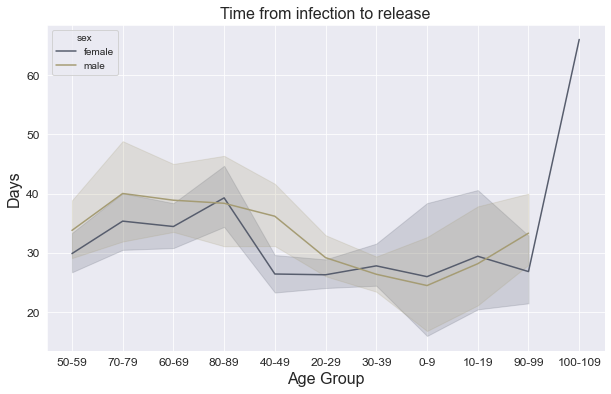

In [37]:
#Lineplot showing time from infection to release among the age groups
sns.lineplot(x='age_group',
            y='time_to_release',           
            data=patient,
            hue='sex',
            palette='cividis')
plt.title('Time from infection to release',fontsize=16)
plt.xlabel('Age Group', fontsize=16)
plt.ylabel('Days', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

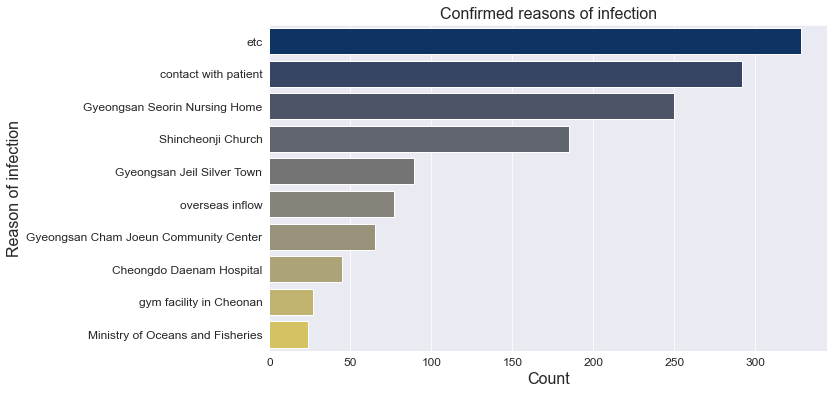

In [38]:
# Reason of infection
sns.set_style("darkgrid")
infection_case = list(patient['infection_case'].value_counts()[:10].index)

sns.countplot(y = 'infection_case',
              data=patient,
              order=infection_case,
              palette='cividis')
plt.title('Confirmed reasons of infection', fontsize=16)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Reason of infection', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

CLASSIFICATION

In [39]:
patient.head()

,sex,age,infection_case,contact_number,state,time_to_release,time_to_death,age_group
0,female,50,overseas inflow,3,deceased,31,5,50-59
1,male,70,Shincheonji Church,3,released,12,4,70-79
2,female,60,Shincheonji Church,3,released,7,4,60-69
3,female,50,Shincheonji Church,3,released,9,4,50-59
4,female,50,Shincheonji Church,3,released,8,4,50-59


In [40]:
#Prepare the new dataset for our classification models
patient_class = patient.drop(columns=['age','time_to_death','time_to_release'], axis = 1)

In [41]:
#Deceased = 0, Released = 1
patient_class['state'] = patient_class['state'].astype('category') 
patient_class['state'] = patient_class['state'].cat.codes

In [40]:
#Show our data for classification
patient_class.head()

,sex,infection_case,contact_number,state,age_group
0,female,overseas inflow,3,0,50-59
1,male,Shincheonji Church,3,1,70-79
2,female,Shincheonji Church,3,1,60-69
3,female,Shincheonji Church,3,1,50-59
4,female,Shincheonji Church,3,1,50-59


In [41]:
#Dummy variables for the categories
patient_class = pd.get_dummies(patient_class, columns= ['sex', 'infection_case', 'age_group'])

In [42]:
#Variables for our classification models
patient_class.head()

,contact_number,state,sex_female,sex_male,infection_case_Bonghwa Pureun Nursing Home,infection_case_Cheongdo Daenam Hospital,infection_case_Guro-gu Call Center,infection_case_Gyeongsan Cham Joeun Community Center,infection_case_Gyeongsan Jeil Silver Town,infection_case_Gyeongsan Seorin Nursing Home,...,age_group_10-19,age_group_100-109,age_group_20-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70-79,age_group_80-89,age_group_90-99
0,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,3,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [43]:
#Split the data into independent variables X and dependent variable y. 
#X is 2-d and Y is 1-d.
#Attributes
X = patient_class.loc[:, patient_class.columns != 'state']
# Target
y = patient_class['state']

In [44]:
#Split into 70% training set and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [46]:
#How many rows and columns now in the data frame:
patient_class.shape

(1427, 33)

In [47]:
# Show the results of the split 
print("Training set has {} samples.".format(X_train.shape[0])) 
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 998 samples.
Testing set has 429 samples.


Note that because the dataset does not provide labels for their testing-set, we need to use the predictions on the training set to compare the algorithms with each other.

In [48]:
#Decision Tree classification
dtree = DecisionTreeClassifier(random_state= 0) 
dtree.fit(X_train, y_train)  
y_pred = dtree.predict(X_test)  
acc_dtree = round(dtree.score(X_train, y_train) * 100, 2)

In [49]:
#Random forest classification
rf = RandomForestClassifier(n_estimators=100, random_state= 0)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf.score(X_train, y_train)
acc_rf = round(rf.score(X_train, y_train) * 100, 2)

In [50]:
#Logistical Regression classification
log = LogisticRegression(random_state=0)
log.fit(X_train, y_train)

y_pred = log.predict(X_test)

acc_log = round(log.score(X_train, y_train) * 100, 2)

In [51]:
#ANN classification
perceptron = Perceptron(max_iter=5, random_state= 0)
perceptron.fit(X_train, y_train)

y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)

In [52]:
#Output the score of each model
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 
              'Logistical Regression', 'Perceptron'],
              'Score': [acc_dtree, acc_rf, acc_log, acc_perceptron]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head()

,Model
Score,
97.49,Decision Tree
97.49,Random Forest
96.49,Logistical Regression
96.49,Perceptron


In [53]:
#Default cross-validation for Random Forest 
cross_val = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy') 

print("Cross Validation Scores:         {}".format(cross_val))
print('Cross Validation Scores - mean:  {:3.4%}'.format(cross_val.mean()))

Cross Validation Scores:         [0.97       0.95       0.97       0.95       0.97       0.97
 0.96       0.92       0.96969697 0.95959596]
Cross Validation Scores - mean:  95.8929%


In [54]:
#Default feature importance for Random Forest 
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(50)

,importance
feature,
contact_number,0.247
age_group_80-89,0.104
age_group_70-79,0.090
infection_case_Shincheonji Church,0.066
age_group_90-99,0.065
sex_male,0.056
sex_female,0.055
infection_case_etc,0.052
infection_case_Cheongdo Daenam Hospital,0.038


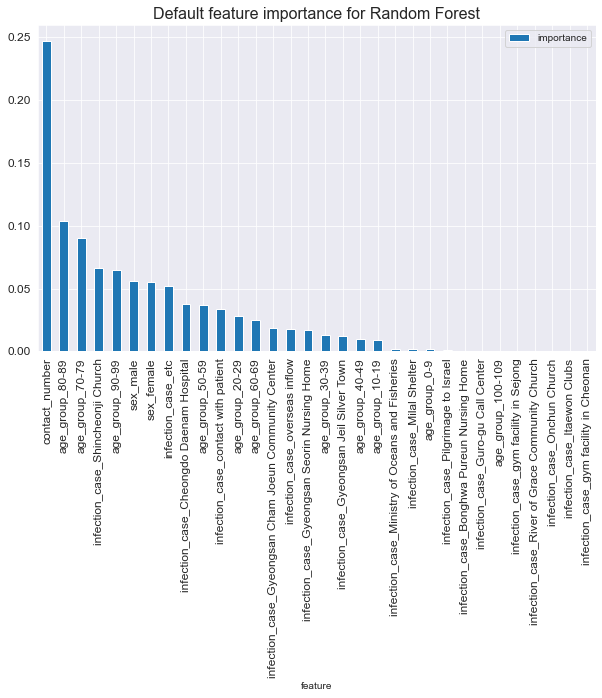

In [55]:
#Default feature importance for Random Forest
importances.plot.bar()

plt.title('Default feature importance for Random Forest', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [56]:
#Drop features with zero importance for Random Forest
X_train_forest_dropped  = X_train.drop(['infection_case_Onchun Church','infection_case_River of Grace Community Church','infection_case_Bonghwa Pureun Nursing Home',
'infection_case_Itaewon Clubs','infection_case_Guro-gu Call Center','infection_case_gym facility in Sejong','infection_case_Pilgrimage to Israel','age_group_100-109'], axis=1)

X_test_forest_dropped  = X_test.drop(['infection_case_Onchun Church','infection_case_River of Grace Community Church','infection_case_Bonghwa Pureun Nursing Home',
'infection_case_Itaewon Clubs','infection_case_Guro-gu Call Center','infection_case_gym facility in Sejong','infection_case_Pilgrimage to Israel','age_group_100-109'], axis=1)

In [57]:
#Fit the final proven best model - Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_forest_dropped,y_train)
print(rf)

# Predict
y_predict = rf.predict(X_test_forest_dropped)
y_predict[0:10]

RandomForestClassifier()


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [60]:
#Final cross_validation for Random Forest after insignificant features dropped
cross_val_dropped = cross_val_score(rf, X_train_forest_dropped, y_train, cv=10, scoring='accuracy') 

print("Cross Validation Scores:         {}".format(cross_val_dropped))
print('Cross Validation Scores - mean:  {:3.4%}'.format(cross_val_dropped.mean()))

Cross Validation Scores:         [0.97       0.95       0.97       0.95       0.97       0.97
 0.96       0.93       0.96969697 0.95959596]
Cross Validation Scores - mean:  95.9929%


In [61]:
#Accuracy of Random Forest
accuracy_score(y_test,y_predict)
print('Accuracy Score:  {:3.4%}'.format(accuracy_score(y_test,y_predict)))

Accuracy Score:  95.5711%


In [62]:
#F1 score Random Forest
f1score = f1_score(y_test, y_predict)
print('F1 Score:  {:3.4%}'.format(f1score))

F1 Score:  97.7246%


In [63]:
#Final feature importance for Random Forest after insignificant variables are dropped
importances_dropped = pd.DataFrame({'feature':X_train_forest_dropped.columns,'importance':np.round(rf.feature_importances_,3)})
importances_dropped = importances_dropped.sort_values('importance',ascending=False).set_index('feature')
importances_dropped.head(15)

,importance
feature,
contact_number,0.241
age_group_70-79,0.101
age_group_80-89,0.100
infection_case_Shincheonji Church,0.072
age_group_90-99,0.068
infection_case_etc,0.055
sex_male,0.054
sex_female,0.052
infection_case_Cheongdo Daenam Hospital,0.041


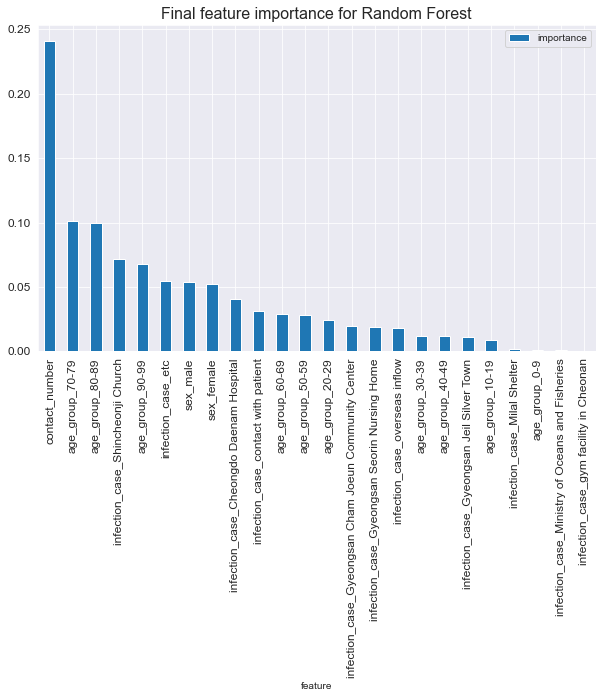

In [64]:
#Final feature importance for Random Forest
importances_dropped.plot.bar()

plt.title('Final feature importance for Random Forest', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Decision Tree

In [65]:
#Default cross-validation for Decision Tree
cross_val_dtree = cross_val_score(dtree, X_train, y_train, cv=10, scoring='accuracy') 

print("Cross Validation Scores:         {}".format(cross_val_dtree))
print('Cross Validation Scores - mean:  {:3.4%}'.format(cross_val_dtree.mean()))

Cross Validation Scores:         [0.97       0.94       0.94       0.93       0.98       0.94
 0.94       0.92       0.95959596 0.94949495]
Cross Validation Scores - mean:  94.6909%


In [66]:
#Default feature importance for Decision Tree
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(dtree.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(50)

,importance
feature,
contact_number,0.252
sex_male,0.166
infection_case_Shincheonji Church,0.122
age_group_70-79,0.084
age_group_80-89,0.082
sex_female,0.070
infection_case_etc,0.064
age_group_90-99,0.034
age_group_60-69,0.031


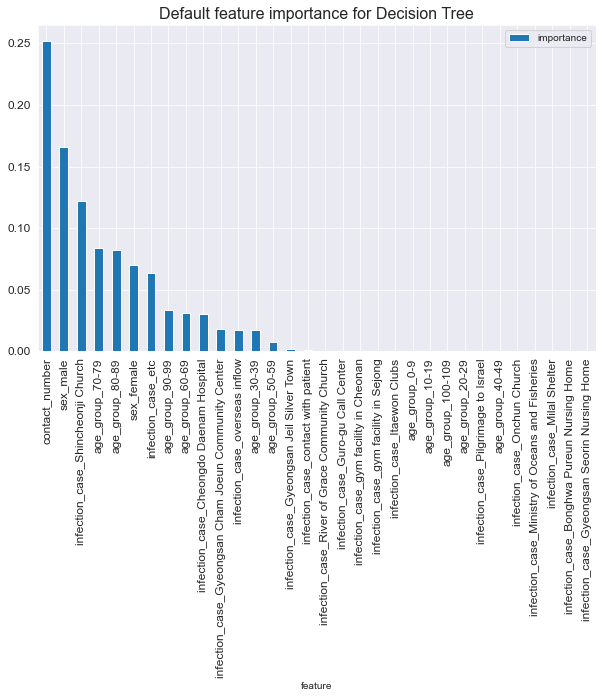

In [67]:
#Default feature importance for Decision Tree
importances.plot.bar()

plt.title('Default feature importance for Decision Tree', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [68]:
#Drop features with zero importance for decision tree
X_train_dtree_dropped  = X_train.drop(['infection_case_Gyeongsan Seorin Nursing Home','infection_case_Bonghwa Pureun Nursing Home','infection_case_Milal Shelter',
'infection_case_Ministry of Oceans and Fisheries','infection_case_Onchun Church','age_group_40-49','infection_case_Pilgrimage to Israel','age_group_20-29',
'age_group_100-109','age_group_10-19','age_group_0-9','infection_case_Itaewon Clubs','infection_case_gym facility in Sejong','infection_case_gym facility in Cheonan',
'infection_case_Guro-gu Call Center','infection_case_River of Grace Community Church'], axis=1)

X_test_dtree_dropped  = X_test.drop(['infection_case_Gyeongsan Seorin Nursing Home','infection_case_Bonghwa Pureun Nursing Home','infection_case_Milal Shelter',
'infection_case_Ministry of Oceans and Fisheries','infection_case_Onchun Church','age_group_40-49','infection_case_Pilgrimage to Israel','age_group_20-29',
'age_group_100-109','age_group_10-19','age_group_0-9','infection_case_Itaewon Clubs','infection_case_gym facility in Sejong','infection_case_gym facility in Cheonan',
'infection_case_Guro-gu Call Center','infection_case_River of Grace Community Church'], axis=1)

In [69]:
#Fit the final proven best model - Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train_dtree_dropped,y_train)
print(dtree)

# Predict
y_predict = dtree.predict(X_test_dtree_dropped)
y_predict[0:10]

DecisionTreeClassifier()


array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [71]:
#Final cross-validation for Decision Tree
cross_val_dtree = cross_val_score(dtree, X_train_dtree_dropped, y_train, cv=10, scoring='accuracy') 

print("Cross Validation Scores:         {}".format(cross_val_dtree))
print('Cross Validation Scores - mean:  {:3.4%}'.format(cross_val_dtree.mean()))

Cross Validation Scores:         [0.97       0.94       0.94       0.95       0.98       0.94
 0.94       0.92       0.95959596 0.94949495]
Cross Validation Scores - mean:  94.8909%


In [72]:
#Accuracy of Decision Tree
accuracy_score(y_test,y_predict)
print('Accuracy Score:  {:3.4%}'.format(accuracy_score(y_test,y_predict)))

Accuracy Score:  94.4056%


In [75]:
#F1 score Decision Tree
f1score = f1_score(y_test, y_predict)
print('F1 Score:  {:3.4%}'.format(f1score))

F1 Score:  97.0732%


In [76]:
#Final feature importance for Decision Tree after insignificant variables are dropped
importances_dropped_dtree = pd.DataFrame({'feature':X_train_dtree_dropped.columns,'importance':np.round(dtree.feature_importances_,3)})
importances_dropped_dtree = importances_dropped_dtree.sort_values('importance',ascending=False).set_index('feature')
importances_dropped_dtree.head(15)

,importance
feature,
contact_number,0.222
sex_female,0.159
infection_case_Shincheonji Church,0.123
sex_male,0.106
age_group_70-79,0.084
age_group_80-89,0.083
infection_case_etc,0.063
age_group_90-99,0.035
infection_case_Cheongdo Daenam Hospital,0.031


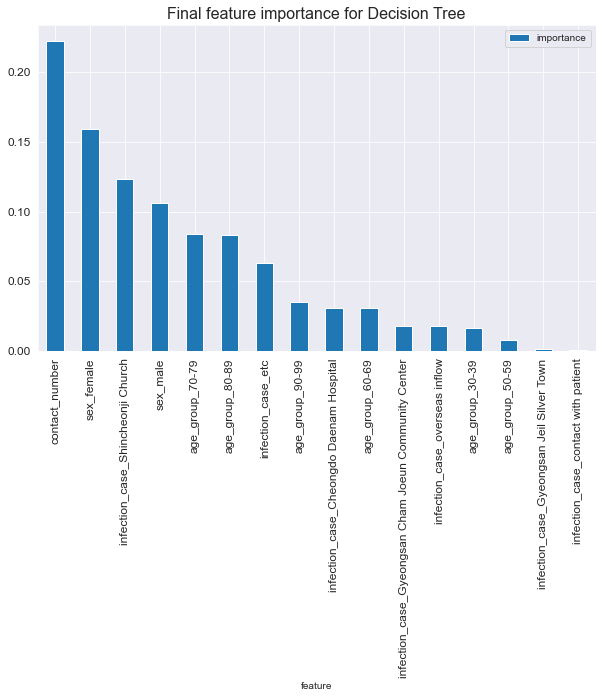

In [77]:
#Final feature importance for Decision Tree
importances_dropped_dtree.plot.bar()

plt.title('Final feature importance for Decision Tree', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()